In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
from infer_utils import load_image

c:\Users\User\Desktop\side_project\vlm\scatterplot_reader\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
generation_config = dict(max_new_tokens=1024, do_sample=False)
background = "On the chart, there's a large cluster of square-shaped points and a diamond-shape point with different color"
sp_prompt = "Your task is to extract the concepts involved in solving the problem"
prompt = f"Question :{background} Given the same x level, does the diamond point higher, slightly higher, lower, slightly lower or overlapping with the square points?\n{sp_prompt}"
analyse_response = model.chat(tokenizer, None, prompt, generation_config)

In [19]:
print(analyse_response)

To solve this problem, we need to analyze the chart and compare the positions of the diamond-shaped point and the square-shaped points at the same x level. Here are the steps to extract the concepts involved in solving the problem:

1. Identify the x level: The x level is the horizontal position on the chart where we want to compare the diamond point and the square points.

2. Locate the diamond point: Find the diamond-shaped point on the chart at the given x level.

3. Locate the square points: Identify all the square-shaped points on the chart at the same x level.

4. Compare the positions: Compare the y-level (vertical position) of the diamond point with the y-levels of the square points.

5. Determine the relationship: Based on the comparison, determine if the diamond point is higher, slightly higher, lower, slightly lower, or overlapping with the square points.

By following these steps, we can extract the concepts involved in solving the problem and determine the relationship bet

In [ ]:
path = "./InternVL2-8B"
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)
generation_config = dict(max_new_tokens=2048, do_sample=False)

model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval().cuda()

In [ ]:
q = f"Instruction : {background}\nQuestion : Do the blue square points higher, slightly higher, lower, slightly lower or overlapping with the red diamond points?\nPlease analysis in detail:"
pixel_values = load_image("testdb_high/testcase_0.png", max_num=12).to(torch.bfloat16).cuda()
generation_config  = dict(max_new_tokens=2048, do_sample=False)
res = model.chat(tokenizer, pixel_values, q, generation_config)
print(res)

In [3]:
from PIL import Image, ImageDraw 
import numpy as np
from copy import deepcopy
import os 
import pandas as pd

def create_masked_images(img, split_num = 7):
    gray_img = img.convert('L')
    axis0 = np.mean((np.array(gray_img) == 0), axis = 0)
    axis1 = np.mean((np.array(gray_img) == 0), axis = 1)
    x0, x1 = np.sort(np.argsort(axis0)[-2:]).tolist()
    y0, y1 = np.sort(np.argsort(axis1)[-2:]).tolist()
    start_end_idx = np.linspace(x0, x1, num=split_num+1).astype(int).tolist() 
    masked_area_tuples = list(zip(start_end_idx[:-1], start_end_idx[1:])) ### [(x0, x1), (x1, x2), ...]

    masked_image_dict = {}
    for idx, keep_masked_area in enumerate(masked_area_tuples):
        masked_image = deepcopy(img)
        for mask in masked_area_tuples:
            if mask != keep_masked_area:
                mask_x0, mask_x1 = mask
                if mask_x0 == x0:
                    mask_x0 += 1 # keep the boundary of chart
                if mask_x1 == x1:
                    mask_x1 += 1 # keep the boundary of chart
                draw = ImageDraw.Draw(masked_image)   
                draw.rectangle((mask_x0, y0+1, mask_x1, y1-1), fill ="white", outline=None) 
        masked_image_dict.update({idx : masked_image})

    return masked_image_dict
    


In [5]:
def create_width_masked_images(img, split_num = 7, width = 8):
    gray_img = img.convert('L')
    axis0 = np.mean((np.array(gray_img) == 0), axis = 0)
    axis1 = np.mean((np.array(gray_img) == 0), axis = 1)
    x0, x1 = np.sort(np.argsort(axis0)[-2:]).tolist()
    y0, y1 = np.sort(np.argsort(axis1)[-2:]).tolist()
    start_end_idx = np.linspace(x0, x1, num=split_num+1).astype(int).tolist() 
    masked_area_tuples = list(zip(start_end_idx[:-1], start_end_idx[1:])) ### [(x0, x1), (x1, x2), ...]

    masked_image_dict = {}
    for idx, keep_masked_area in enumerate(masked_area_tuples):
        masked_image = deepcopy(img)
        mask_x0, mask_x1 = keep_masked_area
        centerx = (mask_x0 + mask_x1)/2 - 2
        draw = ImageDraw.Draw(masked_image)   
        draw.rectangle((x0+1, y0+1, centerx-width, y1-1), fill ="white", outline=None) 
        draw.rectangle((centerx + width, y0+1, x1-1, y1-1), fill ="white", outline=None) 
        # for mask in masked_area_tuples:
        #     if mask != keep_masked_area:
        #         mask_x0, mask_x1 = mask
        #         if mask_x0 == x0:
        #             mask_x0 += 1 # keep the boundary of chart
        #         if mask_x1 == x1:
        #             mask_x1 += 1 # keep the boundary of chart
        #         draw = ImageDraw.Draw(masked_image)   
        #         draw.rectangle((mask_x0, y0+1, mask_x1, y1-1), fill ="white", outline=None) 
        masked_image_dict.update({idx : masked_image})

    return masked_image_dict

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


In [14]:
# tmp_path = "tmp"
# os.makedirs(tmp_path, exist_ok=True)
# image_name = "testcase_1"
# img = Image.open(f"testdb/{image_name}.png").convert('RGB')
# masked_image_dict = create_masked_images(img, split_num=21)
# for idx, mask_img in masked_image_dict.items():
#     mask_img.save(f"{tmp_path}/{image_name}_masked_{idx}.png")

In [5]:
class RelationQA:
    def __init__(self, model, tokenizer, image_path, manual_masked_path = None, split_num = 7, debug = False):
        self.chat_hist = []
        self.debug = debug
        self.image_name = os.path.basename(image_path)
        self.model = model
        self.generation_config  = dict(max_new_tokens=2048, do_sample=False)
        self.tokenizer = tokenizer
        self.relation_q = "Does the {} diamond point higher, slightly higher, lower, slightly lower or overlapping with the {} square points?"
        self.prompts = {
            "background_info" : "On the chart, there's a large cluster of square-shaped points and fewer diamond-shape points with different color",
            "short_ans" : "Answer the question using a single word or phrase.",
            "options" : "Option(A){}, Option(B){}, Option(C){}, Option(D){}, Option(E){}\nAnswer with the option’s letter from the given choices directly."
        }
        self.img, self.mask_image_dict = self.preprocess(image_path, split_num, manual_masked_path)
        self.color_info = self.get_color_info()
        
    def preprocess(self, image_path, split_num, manual_masked_path = None):
        img = Image.open(image_path).convert('RGB')

        if manual_masked_path is None:
            masked_image_dict = create_masked_images(img, split_num)
            if self.debug:
                tmp_path = "tmp_small_slope2"
                os.makedirs(tmp_path, exist_ok=True)
                for idx, mask_img in masked_image_dict.items():
                    mask_img.save(f"{tmp_path}/{self.image_name}_masked_{idx}.png")
        else:
            masked_image_dict = {}
            for idx, filename in enumerate(os.listdir(manual_masked_path)):
                masked_img = Image.open(f"{manual_masked_path}/{filename}").convert('RGB')
                masked_image_dict.update({idx : masked_img})            
        return img, masked_image_dict

    def get_question(self, **kwargs): 
        '''
        kwargs must be in order instruction, question, ans format
        '''
        q = "<image>\n"
        for key, value in kwargs.items():
            if key != "ans_format" :
                q += f"{key}: {value}\n"
            else:
                q += f"{value}\n"

        return q

    #
    def get_color_info(self):
        color_q = "What is the color of {} points?"
        color_dict = {}
        pixel_values = load_image(self.img, max_num=12).to(torch.bfloat16).cuda()
        for shape in ["square", "diamond"]:
            q = self.get_question(Instruction = self.prompts["background_info"],
                                Question =color_q.format(shape), 
                                ans_format = self.prompts["short_ans"])
            response = self.model.chat(self.tokenizer, pixel_values, 
                                    q, self.generation_config)
            if self.debug :
                hist = f'User: {q}\nAssstant: {response}'
                self.chat_hist.append(hist)
                print(hist)
            color_dict.update({shape:response})
        return color_dict 

    # maybe masked image might not exist both diamond and square points
    def check_points_exist(self, pixel_values):
        check_q = "Do any {} {} points exist?" # color, shape
        for shape, color in self.color_info.items():
            q = self.get_question(Question =check_q.format(color, shape), 
                                ans_format = self.prompts["short_ans"] + "Yes or No") 
            response = model.chat(tokenizer, pixel_values, q, self.generation_config)
            if self.debug :
                hist = f'User: {q}\nAssstant: {response}'
                self.chat_hist.append(hist)
                print(hist)

            if "No" in response:
                return False
        return True

    # Directly ask Options will leads bad performance
    def get_masked_ans(self, mask_img):
        pixel_values = load_image(mask_img, max_num=12).to(torch.bfloat16).cuda()
        #if self.check_points_exist(pixel_values):
        #Instruction = analyse_response, 
        final_q = self.get_question(Question = self.relation_q.format("red", "blue")) #self.color_info["diamond"], self.color_info["square"]))
                                #ans_format = self.prompts["options"].format('higher', 'slightly higher', 'lower', 'slightly lower','overlapping with'))
        response = self.model.chat(self.tokenizer, pixel_values, final_q, self.generation_config)
        summary_q = self.get_question(Instruction = response, Question = final_q, 
                    ans_format = self.prompts["options"].format('higher', 'slightly higher', 'lower', 'slightly lower','overlapping with'))
        option = model.chat(tokenizer, None, summary_q, self.generation_config)
        if self.debug :
            hist = f'User: {final_q}\nOption{option}\nAssstant: {response}'
            self.chat_hist.append(hist)
            print(hist)
        return response, option

        #return "Not Exists Both Points", "Not Exists Both Points"

    def inference(self, save_dir = None):
        ans_set = {}
        for idx, mask_img in self.mask_image_dict.items():
            ans, option = self.get_masked_ans(mask_img)
            print(f"idx {idx}, ans {ans}")
            ans_set.update({idx : {"Option" : option, "full_ans" : ans}})
        if save_dir is not None:
            self.save_result(ans_set, save_dir)
                
        return ans_set

    def save_result(self, ans_set, save_dir):
        os.makedirs(save_dir, exist_ok=True)
        pd.DataFrame.from_dict(ans_set, orient='index').to_csv(f"{save_dir}/{self.image_name}.csv")
        if len(self.chat_hist) > 0:
            with open(f'{save_dir}/{self.image_name}_chat_hist.txt', 'a') as file:
                file.write("\n".join(self.chat_hist))
    #def get_prob(self)
    

In [8]:
q = f"Question : Do the blue square points higher, slightly higher, lower, slightly lower or overlapping with the red diamond point?\n"
pixel_values = load_image("manual_masked/testcase0_masked_2_solid.png", max_num=12).to(torch.bfloat16).cuda()
generation_config  = dict(max_new_tokens=2048, do_sample=False)
res = model.chat(tokenizer, pixel_values, q, generation_config)
print(res)


The blue square points slightly higher than the red diamond point.


In [6]:
rel_qa = RelationQA(model, tokenizer, f"testdb_small_slope_2/testcase_0.png", split_num = 7, debug = True)
rel_qa.color_info
ans_set = rel_qa.inference("result_small_slope2_split_7")

User: <image>
Instruction: On the chart, there's a large cluster of square-shaped points and fewer diamond-shape points with different color
Question: What is the color of square points?
Answer the question using a single word or phrase.

Assstant: Blue
User: <image>
Instruction: On the chart, there's a large cluster of square-shaped points and fewer diamond-shape points with different color
Question: What is the color of diamond points?
Answer the question using a single word or phrase.

Assstant: Red
User: <image>
Question: Does the red diamond point higher, slightly higher, lower, slightly lower or overlapping with the blue square points?

OptionB
Assstant: The red diamond point is slightly higher than the blue square point.
idx 0, ans The red diamond point is slightly higher than the blue square point.
User: <image>
Question: Does the red diamond point higher, slightly higher, lower, slightly lower or overlapping with the blue square points?

OptionB
Assstant: The red diamond point

In [33]:
save_dir = "result_split_7"
for filename in os.listdir("testdb"):
    if ("png" in filename) and (f"{filename}.csv" not in os.listdir(save_dir)):
        print(f"------ Start inference {filename} ------")
        rel_qa = RelationQA(model, tokenizer, f"testdb/{filename}", split_num = 7, debug = True)
        rel_qa.color_info
        ans_set = rel_qa.inference(save_dir)

------ Start inference testcase_1.png ------
User: <image>
Instruction: On the chart, there's a large cluster of square-shaped points and fewer diamond-shape points with different color
Question: What is the color of square points?
Answer the question using a single word or phrase.

Assstant: Blue
User: <image>
Instruction: On the chart, there's a large cluster of square-shaped points and fewer diamond-shape points with different color
Question: What is the color of diamond points?
Answer the question using a single word or phrase.

Assstant: Red
User: <image>
Question: Do any Blue square points exist?
Answer the question using a single word or phrase.Yes or No

Assstant: Yes
User: <image>
Question: Do any Red diamond points exist?
Answer the question using a single word or phrase.Yes or No

Assstant: Yes
User: <image>
Question: Does the Red diamond point higher, slightly higher, lower, slightly lower or overlapping with the Blue square points?

OptionD
Assstant: The Red diamond point 

KeyboardInterrupt: 

In [20]:
import pandas as pd
pd.DataFrame.from_dict(ans_set, orient='index').to_csv("tmp.csv")

In [14]:
q_orig = "Does the {} diamond point higher, slightly higher, lower, slightly lower or overlapping with the {} square points?".format("red", "blue")
option_prompt = "Option(A){}, Option(B){}, Option(C){}, Option(D){}, Option(E){}\nAnswer with the option’s letter from the given choices directly.".format('higher', 'slightly higher', 'lower', 'slightly lower','overlapping with')
for idx, ans in ans_set.items():
    question = f"Instruction:{ans}, Question : {q_orig}\n{option_prompt}"
    response = model.chat(tokenizer, None, question, rel_qa.generation_config)
    print(f"idx {idx} response {response}")


idx 0 response D
idx 1 response C
idx 2 response D
idx 3 response D
idx 4 response D
idx 5 response D
idx 6 response D


User: <image>
Question: Do any Blue square points exist?
Answer the question using a single word or phrase.Yes or No

Assstant: Yes
User: <image>
Question: Do any Red diamond points exist?
Answer the question using a single word or phrase.Yes or No

Assstant: Yes
User: <image>
Question: Does the Red diamond point higher, slightly higher, lower, slightly lower or overlapping with the Blue square points?

Assstant: The red diamond point is slightly lower than the blue square points.
idx 0, ans The red diamond point is slightly lower than the blue square points.
User: <image>
Question: Do any Blue square points exist?
Answer the question using a single word or phrase.Yes or No

Assstant: Yes
User: <image>
Question: Do any Red diamond points exist?
Answer the question using a single word or phrase.Yes or No

Assstant: Yes
User: <image>
Question: Does the Red diamond point higher, slightly higher, lower, slightly lower or overlapping with the Blue square points?

Assstant: The red diamond p

In [7]:
background_info = "On the chart, there's a large cluster of square-shaped points and fewer diamond-shape points with different color"
pixel_values = load_image(f'./testdb/testcase_1.png', max_num=12).to(torch.bfloat16).cuda()

short_ans_prompt = "Answer the question using a single word or phrase."
color_ans = "What is the color of {} points?"
color_dict = {}
for shape in ["square", "diamond"]:
    question = f'<image>\nInstruct:{background_info}\nQuestion: {color_ans.format(shape)}\n{short_ans_prompt}'
    response = model.chat(tokenizer, pixel_values, question, generation_config)
    color_dict.update({shape:response})

print(f'User: {question}\nAssstant: {color_dict}')

User: <image>
Instruct:On the chart, there's a large cluster of square-shaped points and fewer diamond-shape points with different color
Question: What is the color of diamond points?
Answer the question using a single word or phrase.
 Assstant: {'square': 'Blue', 'diamond': 'Red'}


In [122]:
# set the max number of tiles in `max_num`
background_info = "On the chart, there's a large cluster of square-shaped points and fewer diamond-shape points with different color"





pixel_values = load_image(f'./{tmp_path}/testcase_1_masked_2.png', max_num=12).to(torch.bfloat16).cuda()
ques_1 = "Is there any red diamond point?"
ques_orig = "Does the diamond point higher, slightly higher, lower, slightly lower or overlapping with the square points?"
option = ""

question = '<image>\nPlease describe the image shortly.'
question = '<image>\nWhat is the title of the scatterplot?'
question = f'<image>\nQuestion: {ques_1}'
response = model.chat(tokenizer, pixel_values, question, generation_config)

print(f'User: {question}\nAssistant: {response}')

User: <image>
Question: Is there any red diamond point ?
Assistant: No, there is no red diamond point.


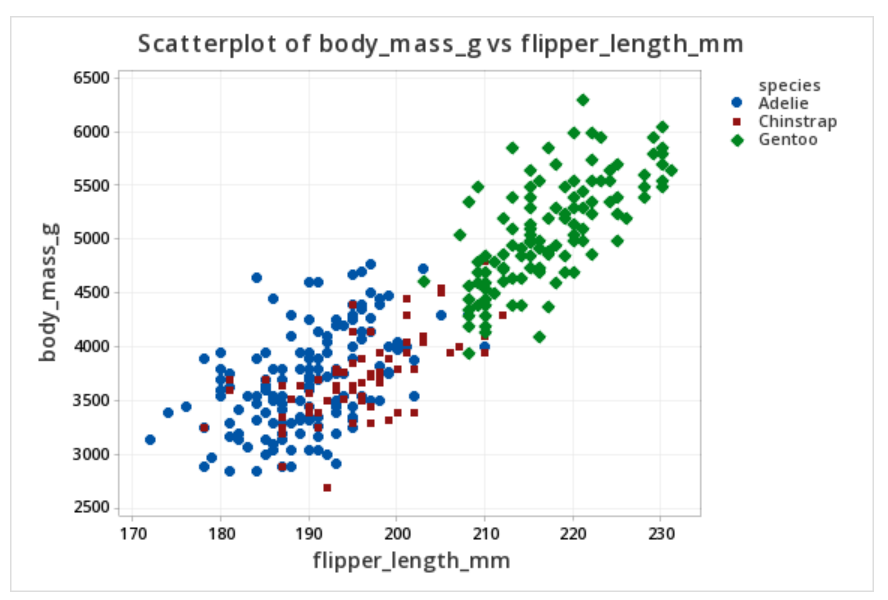

In [6]:
from PIL import Image

image = Image.open('./DB/test1.png')
image